# import libraries

In [1]:
import matplotlib.pyplot as plt
from platform import python_version
import matplotlib
from datetime import datetime
import time
import numpy as np
import cv2
import os

In [2]:
print('python       {}'.format(python_version()))
print('numpy        {}'.format(np.__version__))
print('cv2          {}'.format(cv2.__version__))
print('matplotlib   {}'.format(matplotlib.__version__))

python       3.8.8
numpy        1.19.5
cv2          4.5.2
matplotlib   3.3.4


In [19]:
def DetectGlomeruli(InputImage,probability=0.5,threshold=0.3,frame_color=[255,255,255]):
    
    #-------------------------------- prepare InputImage for the Network -----------------------
    
    
    image_BGR = InputImage.copy() # image_BGR to use for prediction, InputImage remain untouched
    h, w = image_BGR.shape[:2] # get the shapes of the InputImages
    
    # scale the InputImage for the Network of the size 461,416 and normalize between 0 and 1
    blob = cv2.dnn.blobFromImage(image_BGR, 1 / 255.0, (416, 416),swapRB=True, crop=False)
    
    labels = ['Glomeruli'] # one label because the network is trained to detect healthy Glomeruli
    
    
    
    #-------------------------------- Prepare the network and read the weights   -----------------
    
    network = cv2.dnn.readNetFromDarknet('weights/GlomeruliDetection.cfg',
                                         'weights/GlomeruliDetection.weights')
    
    layers_names_all = network.getLayerNames()
    layers_names_output = [layers_names_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]
    
    
    #---------------------------define parameters to handle with the output of the network   -----------------
    
    # weak prediction (based on choosed threshold) will be eliminated
    probability_minimum = probability 
    
    # with non-maximum suppression
    threshold = threshold
    
    # define the color of the frame in RGB [255,255,255] white
    colours = np.array([frame_color], dtype='uint8') # white 
    
    
    #--------------------------- -------     Prediction      --------------------------
    network.setInput(blob)  # setting blob as input to the network
    start = time.time()
    output_from_network = network.forward(layers_names_output)
    end   = time.time()
    


    #-------  The Prediction is done - Now is time to handle with the output of the network -------------------

    bounding_boxes = []
    confidences = []
    class_numbers = []
    
    # Going through all detections from current ouput layer --> layers_names_output
    for result in output_from_network:
        
        for detected_objects in result:       # in our case we have one class for each detection
            scores = detected_objects[5:]     # Getting position of the class with the maximum value of probability
            class_current = np.argmax(scores) # Getting value of probability for defined class
            confidence_current = scores[class_current]

               # Eliminate detections based on defined probability
            if confidence_current > probability_minimum:
                # getting the coordinates of the detected_object in respect to the size of the InputImage 
                box_current = detected_objects[0:4] * np.array([w, h, w, h])

                # Now, from YOLO data format, we can get top left corner coordinates
                # that are x_min and y_min
                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                # Adding results into prepared lists
                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)
                
    # a function of cv2 for Suppresion of bounding boxes
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences,
                           probability_minimum, threshold)
    
    
    
    #-------  Now we get the correct detection and the corresponding bounding_boxes - 
    #----------Time for Visualization of the Ouput and to create frames on the InputImage -------

    
    if len(results) > 0: # if there any detected object !
    # Going through indexes of results
        for i in results.flatten():

            # Getting current bounding box coordinates,
            # its width and height
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

            # Preparing colour for current bounding box
            # and converting from numpy array to list
            colour_box_current = colours[class_numbers[i]].tolist()


            # Drawing bounding box on the original image
            cv2.rectangle(image_BGR, (x_min, y_min),
                          (x_min + box_width, y_min + box_height),
                          colour_box_current, 2)

            # Preparing text with label and confidence for current bounding box
            text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])],
                                                   confidences[i])

            # Putting text with label and confidence on the original image
            cv2.putText(image_BGR, text_box_current, (x_min, y_min - 5),
                        cv2.FONT_HERSHEY_COMPLEX, 0.7, colour_box_current, 2)

        return image_BGR

    
    


In [20]:
prediction = DetectGlomeruli(image_BGR,probability=0.5)

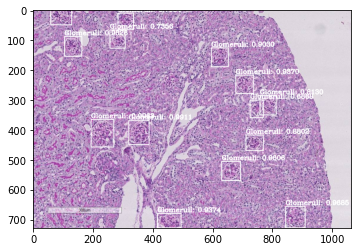

In [21]:
plt.imshow(prediction)

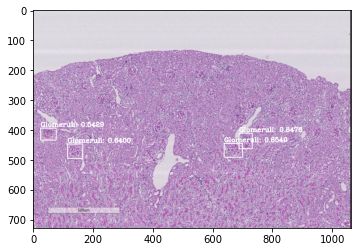

In [8]:
image_BGR = cv2.imread('Images/PAS_4.8X_1.jpg')
image_BGR = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
prediction = DetectGlomeruli(image_BGR,probability=0.5)
plt.imshow(prediction)

In [70]:
prediction

In [18]:
for i in os.listdir('Images/'):
    image_BGR  = cv2.imread('Images/'+i)
    image_BGR  = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
    prediction = DetectGlomeruli(image_BGR,probability=0.2)
    prediction = np.concatenate((image_BGR,prediction),axis=1)
    plt.imsave('Prediction/'+i, prediction)
    

In [ ]:
plt.figure(figsize=(12,8))
image_BGR = cv2.imread('Images/Jones_7.8X_2.jpg')
image_BGR = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
plt.imshow(image_BGR)  # BlueGreenRed instaed of RedGreenBlue !